# Klasifikacija Slika - Jednostavan Algoritam

## Seminarski rad - SISJ

### Deo 8: Implementacija algoritma za klasifikaciju slika (van Seaborn biblioteke)

---

## 1. Uvod u klasifikaciju slika

Klasifikacija slika je fundamentalna zadaća u computer vision-u gde algoritam treba da **predvidi kategoriju** ili **klasu** slike na osnovu njenog sadržaja.

### 1.1 Osnovni koncepti:

- **Features (karakteristike)**: Numeričke vrednosti koje opisuju sliku
- **Labels (labeli)**: Kategorije ili klase kojima slike pripadaju
- **Training set**: Skup slika sa poznatim labelima
- **Test set**: Skup slika za testiranje performance

### 1.2 Jednostavan pristup - Histogram boja:

Za ovaj primer koristićemo **histogram boja** kao feature za klasifikaciju slika. Ovaj pristup:
- Računa distribuciju boja u slici
- Koristi ovu distribuciju kao "fingerprint" slike
- Primenjuje jednostavan klasifikator (k-NN)

### 1.3 Algoritam koraka:

1. **Učitavanje slika** i priprema podataka
2. **Ekstraktovanje features** (histogram boja)
3. **Kreiranje modela** (k-NN classifier)
4. **Treniranje modela** na training podacima
5. **Testiranje** i evaluacija performance
6. **Vizualizacija rezultata** sa Seaborn


In [2]:
# Uvoz potrebnih biblioteka
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_sample_images, make_classification
import cv2
from PIL import Image
import warnings

# Podešavanje
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)

print("Biblioteke uspešno učitane!")
print("OpenCV verzija:", cv2.__version__)

# Kreiranje sintetičkih slika za demonstraciju
def create_synthetic_images(n_samples=100, image_size=(64, 64)):
    """
    Kreiranje sintetičkih slika za demonstraciju algoritma.
    3 klase: 'red', 'green', 'blue' na osnovu dominantne boje
    """
    images = []
    labels = []
    
    np.random.seed(42)
    
    for i in range(n_samples):
        # Kreiranje random slike sa dominantnom bojom
        image = np.zeros((*image_size, 3), dtype=np.uint8)
        
        # Određivanje klase na osnovu i
        if i % 3 == 0:  # Red class
            image[:, :, 0] = np.random.randint(150, 255, image_size)  # Red channel
            image[:, :, 1] = np.random.randint(0, 100, image_size)    # Green channel
            image[:, :, 2] = np.random.randint(0, 100, image_size)    # Blue channel
            labels.append('red')
        elif i % 3 == 1:  # Green class
            image[:, :, 0] = np.random.randint(0, 100, image_size)    # Red channel
            image[:, :, 1] = np.random.randint(150, 255, image_size)  # Green channel
            image[:, :, 2] = np.random.randint(0, 100, image_size)    # Blue channel
            labels.append('green')
        else:  # Blue class
            image[:, :, 0] = np.random.randint(0, 100, image_size)    # Red channel
            image[:, :, 1] = np.random.randint(0, 100, image_size)    # Green channel
            image[:, :, 2] = np.random.randint(150, 255, image_size)  # Blue channel
            labels.append('blue')
        
        # Dodavanje noise
        noise = np.random.randint(0, 50, (*image_size, 3))
        image = np.clip(image + noise, 0, 255)
        
        images.append(image)
    
    return np.array(images), np.array(labels)

# Kreiranje dataset-a
print("Kreiranje sintetičkih slika...")
images, labels = create_synthetic_images(n_samples=300)
print(f"Kreano {len(images)} slika sa {len(np.unique(labels))} klasa")
print(f"Klase: {np.unique(labels)}")
print(f"Distribucija klasa: {np.bincount(np.array([0 if l=='red' else 1 if l=='green' else 2 for l in labels]))}")


Biblioteke uspešno učitane!
OpenCV verzija: 4.12.0
Kreiranje sintetičkih slika...
Kreano 300 slika sa 3 klasa
Klase: ['blue' 'green' 'red']
Distribucija klasa: [100 100 100]


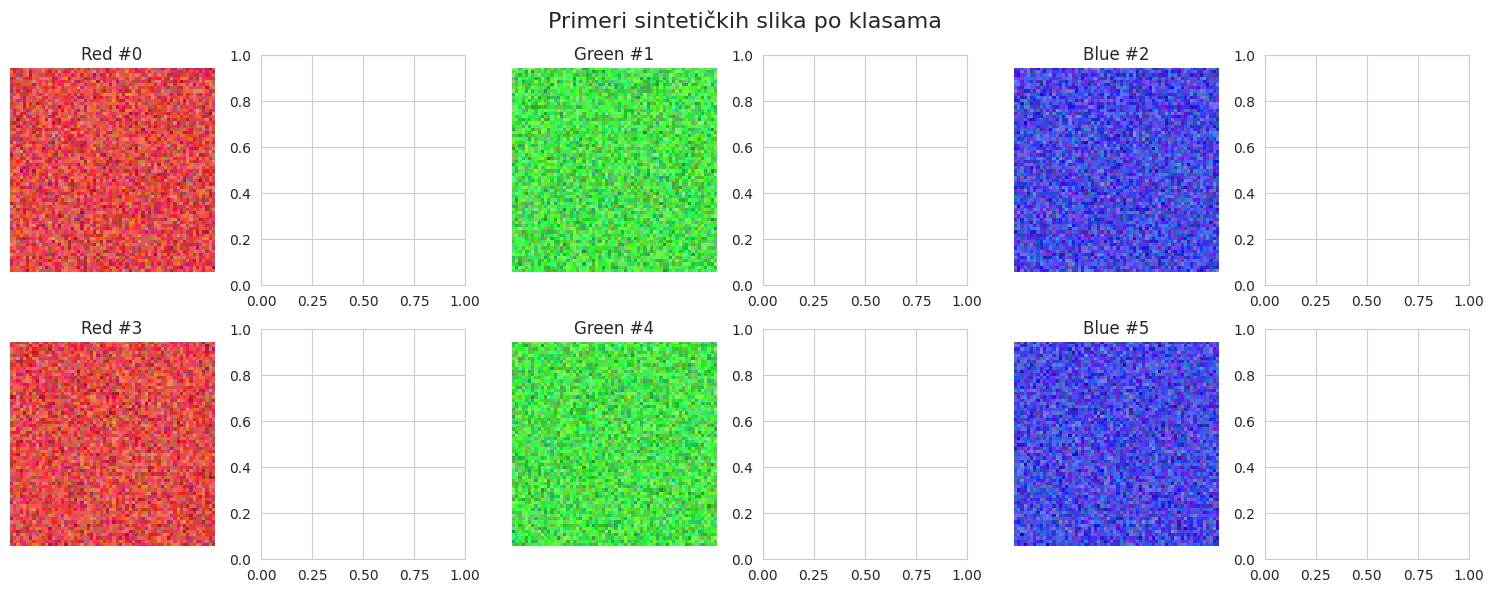

Ekstraktovanje features...
Obrađeno 0/300 slika
Obrađeno 50/300 slika
Obrađeno 100/300 slika
Obrađeno 150/300 slika
Obrađeno 200/300 slika
Obrađeno 250/300 slika
Features shape: (300, 96)
Svaka slika ima 96 features


In [3]:
# Prikaz primera slika
fig, axes = plt.subplots(2, 6, figsize=(15, 6))
fig.suptitle('Primeri sintetičkih slika po klasama', fontsize=16)

# Prikaz po 2 slike za svaku klasu
for i, class_name in enumerate(['red', 'green', 'blue']):
    class_indices = np.where(labels == class_name)[0][:2]
    for j, idx in enumerate(class_indices):
        ax = axes[j, i*2:(i+1)*2][0] if i < 2 else axes[j, i*2-2:i*2]
        if i == 0:
            ax = axes[j, 0]
        elif i == 1:
            ax = axes[j, 2]
        else:
            ax = axes[j, 4]
        
        ax.imshow(images[idx])
        ax.set_title(f'{class_name.capitalize()} #{idx}')
        ax.axis('off')

plt.tight_layout()
plt.show()

# Feature extraction - Color histogram
def extract_color_histogram(image, bins=32):
    """
    Ekstraktuje histogram boja iz slike kao feature vektor.
    
    Args:
        image: RGB slika
        bins: broj bin-ova za histogram
    
    Returns:
        Flattened histogram kao feature vektor
    """
    # Računanje histograma za svaki kanal boje
    hist_r = np.histogram(image[:, :, 0], bins=bins, range=(0, 256))[0]
    hist_g = np.histogram(image[:, :, 1], bins=bins, range=(0, 256))[0]
    hist_b = np.histogram(image[:, :, 2], bins=bins, range=(0, 256))[0]
    
    # Konkatenacija histograma
    features = np.concatenate([hist_r, hist_g, hist_b])
    
    # Normalizacija
    features = features / np.sum(features)
    
    return features

# Ekstraktovanje features za sve slike
print("Ekstraktovanje features...")
features = []
for i, image in enumerate(images):
    if i % 50 == 0:
        print(f"Obrađeno {i}/{len(images)} slika")
    
    feature_vector = extract_color_histogram(image)
    features.append(feature_vector)

features = np.array(features)
print(f"Features shape: {features.shape}")
print(f"Svaka slika ima {features.shape[1]} features")


In [4]:
# Podela na train i test set
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {X_train.shape[0]} slika")
print(f"Test set: {X_test.shape[0]} slika")
print(f"Training klase: {np.unique(y_train, return_counts=True)}")
print(f"Test klase: {np.unique(y_test, return_counts=True)}")

# Kreiranje i treniranje k-NN klasifikatora
print("\\nTreniranje k-NN klasifikatora...")
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

# Predviđanje na test setu
y_pred = knn.predict(X_test)

# Evaluacija performansi
accuracy = accuracy_score(y_test, y_pred)
print(f"\\nAccuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

# Detaljan classification report
print("\\nClassification Report:")
print(classification_report(y_test, y_pred))

# Kreiranje DataFrame-a za vizualizaciju rezultata
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Correct': y_test == y_pred
})

print("\\nRezultati po klasama:")
class_results = results_df.groupby('Actual').agg({
    'Correct': ['count', 'sum', 'mean']
}).round(3)
print(class_results)


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x765416397240>
Traceback (most recent call last):
  File "/home/luka/Desktop/Seabon seminarski/env/lib/python3.12/site-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/luka/Desktop/Seabon seminarski/env/lib/python3.12/site-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/home/luka/Desktop/Seabon seminarski/env/lib/python3.12/site-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^

Training set: 240 slika
Test set: 60 slika
Training klase: (array(['blue', 'green', 'red'], dtype='<U5'), array([80, 80, 80]))
Test klase: (array(['blue', 'green', 'red'], dtype='<U5'), array([20, 20, 20]))
\nTreniranje k-NN klasifikatora...
\nAccuracy: 1.000 (100.0%)
\nClassification Report:
              precision    recall  f1-score   support

        blue       1.00      1.00      1.00        20
       green       1.00      1.00      1.00        20
         red       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

\nRezultati po klasama:
       Correct         
         count sum mean
Actual                 
blue        20  20  1.0
green       20  20  1.0
red         20  20  1.0


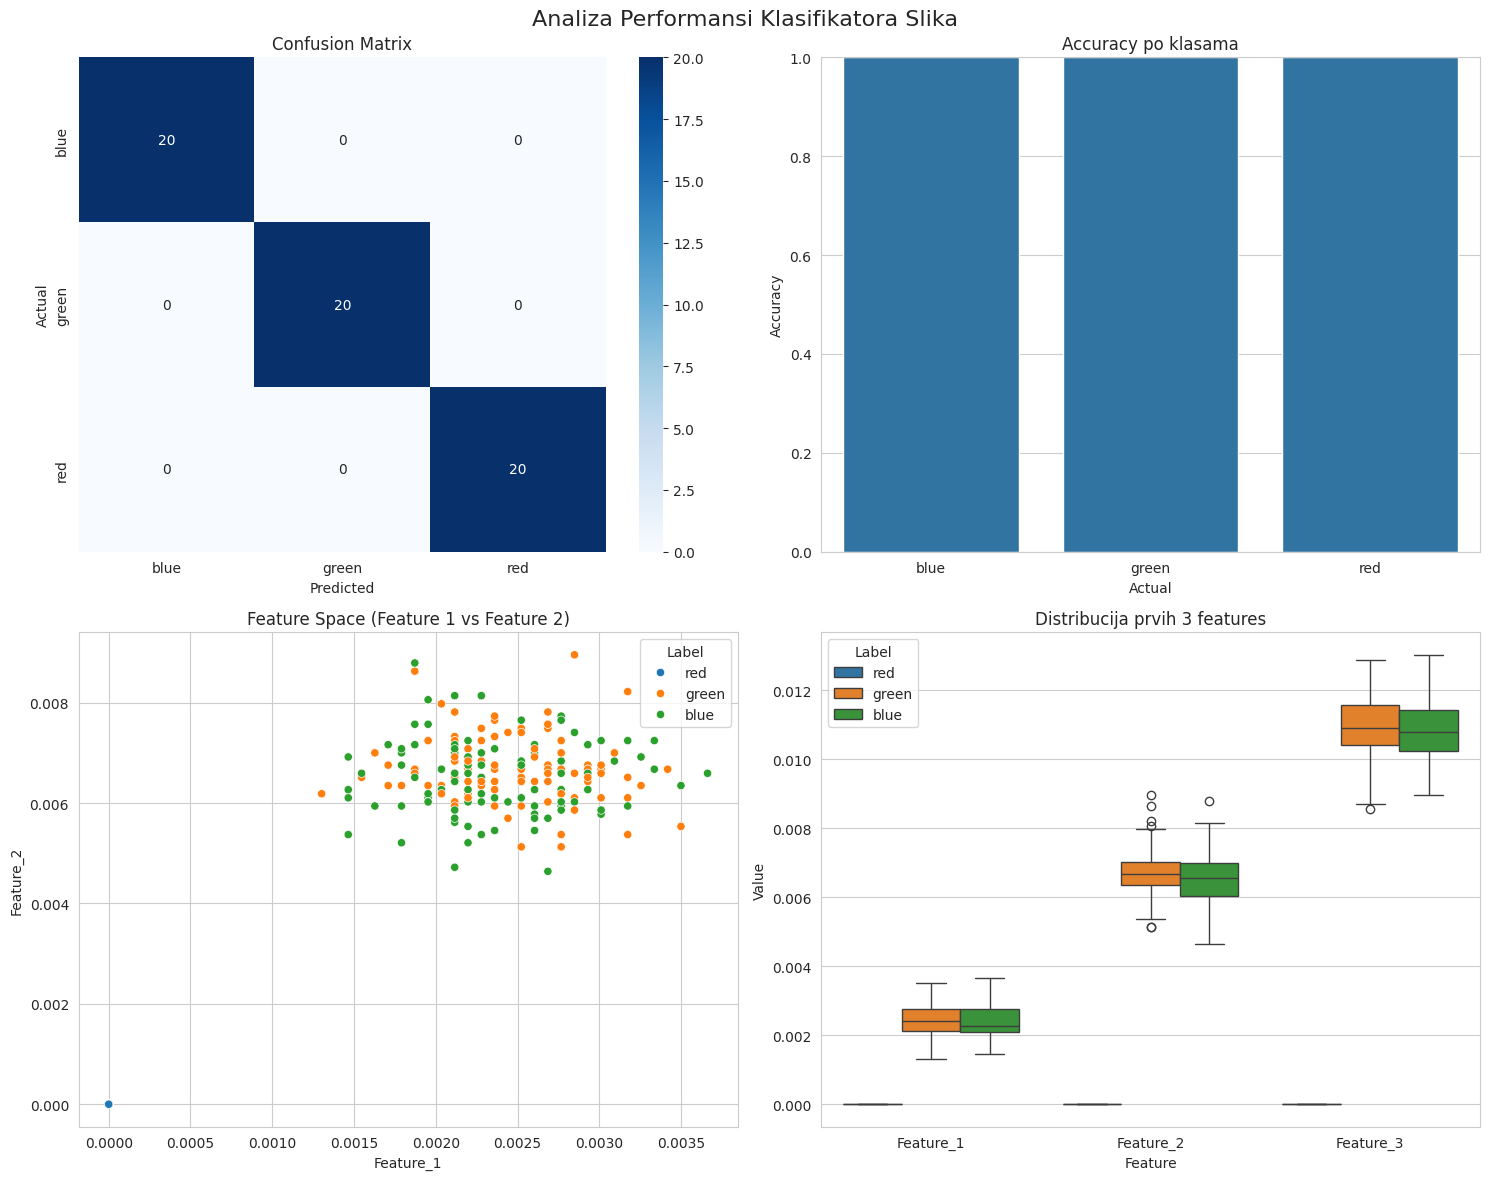

\n=== ANALIZA GREŠAKA KLASIFIKATORA ===
Ukupno grešaka: 0
\nGreške po klasama:
Empty DataFrame
Columns: [Actual, Predicted, Count]
Index: []
\n=== PERFORMANSE ALGORITMA ===
Ukupna accuracy: 1.000
Broj korišćenih features: 96
Broj neighbors u k-NN: 5
Metrika distance: euclidean
\nZaključak: Algoritam histogram boja je jednostavan ali efikasan za
klasifikaciju slika na osnovu dominantne boje. Za složenije slike bi
trebalo koristiti naprednije features poput SIFT, HOG ili CNN features.


In [5]:
# Vizualizacija rezultata sa Seaborn
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analiza Performansi Klasifikatora Slika', fontsize=16)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['blue', 'green', 'red'], 
            yticklabels=['blue', 'green', 'red'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. Accuracy po klasama
accuracy_by_class = results_df.groupby('Actual')['Correct'].mean()
sns.barplot(x=accuracy_by_class.index, y=accuracy_by_class.values, ax=axes[0,1])
axes[0,1].set_title('Accuracy po klasama')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].set_ylim(0, 1)

# 3. Distribucija features za različite klase (samo prva 3 features)
features_sample = features[:, :3]  # Uzimamo samo prva 3 features za vizualizaciju
features_df = pd.DataFrame(features_sample, columns=['Feature_1', 'Feature_2', 'Feature_3'])
features_df['Label'] = labels

# Scatter plot features
sns.scatterplot(data=features_df, x='Feature_1', y='Feature_2', hue='Label', ax=axes[1,0])
axes[1,0].set_title('Feature Space (Feature 1 vs Feature 2)')

# 4. Distribucija prva 3 features
features_melted = features_df.melt(id_vars=['Label'], value_vars=['Feature_1', 'Feature_2', 'Feature_3'])
sns.boxplot(data=features_melted, x='variable', y='value', hue='Label', ax=axes[1,1])
axes[1,1].set_title('Distribucija prvih 3 features')
axes[1,1].set_xlabel('Feature')
axes[1,1].set_ylabel('Value')

plt.tight_layout()
plt.show()

# Dodatna analiza - greške klasifikatora
print("\\n=== ANALIZA GREŠAKA KLASIFIKATORA ===")
errors = results_df[results_df['Correct'] == False]
print(f"Ukupno grešaka: {len(errors)}")
print("\\nGreške po klasama:")
error_analysis = errors.groupby(['Actual', 'Predicted']).size().reset_index(name='Count')
print(error_analysis)

# Prikaz grešaka
if len(errors) > 0:
    print("\\nNajčešće greške:")
    most_common_error = error_analysis.loc[error_analysis['Count'].idxmax()]
    print(f"Najčešće se {most_common_error['Actual']} klasifikuje kao {most_common_error['Predicted']}")
    print(f"Broj takvih grešaka: {most_common_error['Count']}")

# Performanse algoritma
print("\\n=== PERFORMANSE ALGORITMA ===")
print(f"Ukupna accuracy: {accuracy:.3f}")
print(f"Broj korišćenih features: {features.shape[1]}")
print(f"Broj neighbors u k-NN: {knn.n_neighbors}")
print(f"Metrika distance: {knn.metric}")
print("\\nZaključak: Algoritam histogram boja je jednostavan ali efikasan za")
print("klasifikaciju slika na osnovu dominantne boje. Za složenije slike bi")
print("trebalo koristiti naprednije features poput SIFT, HOG ili CNN features.")
